In [1]:
var openDigger = require('../src/open_digger');

# Notebook handbook

This is an example notebook of OpenDigger to show how to use OpenDigger to analysis open source data.

## Function Groups

There are several function groups you can use to get data from OpenDigger, like `render`, `label`, `quick`, `index`, `metric`, `relation`, `driver`.

### Render

As we use JupyterLab to analysis the data, we provide the [`plotyly`](https://plotly.com/javascript/) interface to draw the graphs.

You can access plotly function like `openDigger.render.plotly(data, config)`;

As for drawing table, you can directly use `console.table` of Node.js.

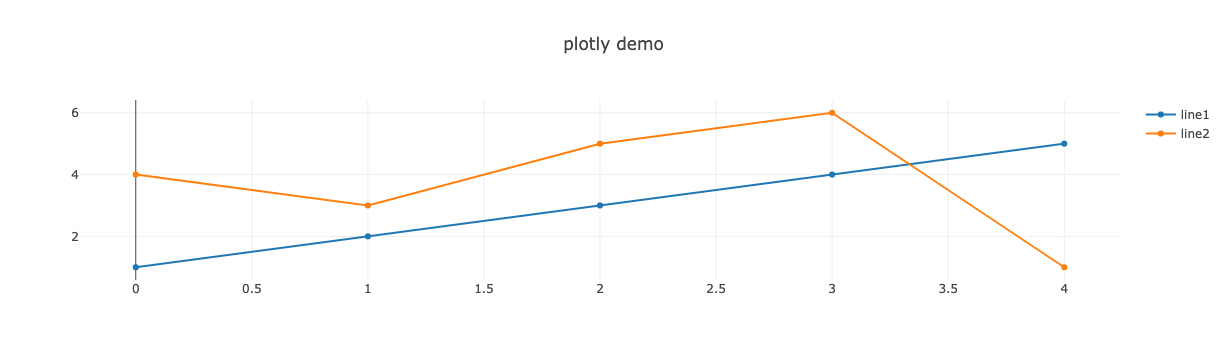

┌─────────┬────────┬───────┐
│ (index) │  name  │ score │
├─────────┼────────┼───────┤
│    0    │ 'John' │  2.4  │
│    1    │ 'Lily' │  3.2  │
└─────────┴────────┴───────┘


In [2]:
openDigger.render.plotly([{y: [1,2,3,4,5],name: 'line1'}, {y: [4,3,5,6,1],name: 'line2'}], {title: 'plotly demo'});
console.table([{name: 'John', score:2.4}, {name: 'Lily',score: 3.2}]);

### Label

In OpenDigger, we have lots of labeled data for repositories like Company, Foundation, China and etc.

You can use `openDigger.label.getLabelData()` to get all the labels and use `openDigger.label.getGitHubData(typeOrIds: string[])` to get GitHub data of certain labels.

The `openDigger.label.getLabelData()` will return an array with item structure like:

``` javascript
{
    identifier: string;     // The identifier of the label, like :companies/alibaba or :foundations/apache
    type: string;           // The type of the label, like Company or Foundation
    name: string;           // Name of the label, like Alibaba or Apache Software Foundation
    githubRepos: number[];  // GitHub repository ids under this label
    githubOrgs: number[];   // GitHub organization ids under this label
    githubUsers: number[];  // GitHub user ids under this label
}
```

The `openDigger.label.getGitHubData(typeOrIds: string[])` function accepts an array with label identifiers or types to get all the repository, organization and user ids under the labels.

In [3]:
var labelData = openDigger.label.getLabelData();
console.log(`OpenDigger has ${labelData.length} labels with ${new Set(labelData.map(l => l.type)).size} types`);

OpenDigger has 226 labels with 9 types


In [4]:
var data = openDigger.label.getGitHubData(['Foundation', 'Company']);
console.log(`There are ${data.githubRepos.length} repos and ${data.githubOrgs.length} orgs for all foundation and company labels`);

There are 154 repos and 327 orgs for all foundation and company labels


### Index

In OpenDigger, we provide indexe implementations for users to dive into the data.

#### Activity Index

Activity index is the basic inde introduced by X-lab, activity index uses `IssueCommentEvent`, `IssuesEvent`, `PullRequestEvent` and `PullRequestReviewCommentEvent` in GitHub event log.

You can use `openDigger.index.activity.getRepoActivity(config)` to get activity index of certain projects.

The `config` structure is like below:

``` javascript
{
    labelUnion?: string[];                       // use to get all repos have any label in the array
    labelIntersect?: string[];                   // use to get all repos have all the labels in the array
    repoIds?: number[];                          // specific repo id array
    repoNames?: string[];                        // specific repo name array
    orgIds?: number[];                           // specific org id array
    orgNames?: string[];                         // specific org name array
    userIds?: number[];                          // specific user id array, used in user query
    userLogins?: string[];                       // specific user login array, used in user query
    startYear?: number = 2015;                   // start year of the data, default: 2015
    startMonth?: number = 1;                     // start month of the data, default: 1
    endYear?: number = current_year;             // end year of the data, default: current year
    endMonth?: number = last_month;              // end month of the data, default: last month 
    order?: 'DESC' | 'ASC';                      // return data order by DESC or ASC, default: not order
    limitOption: 'each' | 'all' = 'all';         // how limit work, limit for each time period or for all results, default: all
    limit?: number = 10;                         // the limit of return records, default: 10
    percision?: number = 2;                      // the percision of the float number like activity or openrank, default: 2
    groupBy?: 'org' | string;                    // how to group repos, by org or any label type like Company. default: null, return by repo
    groupTimeRange?: 'month' | 'season' | 'year';// how to group by time, by month, season or year, default: null, return all data in a row
}
```

> ***This config will be used for all index and metrics query.***

It may suit all the data analysis needs by modify the config.

- getRepoActivity

This function will return the repo activity with the config param.

Here is an example of all Chinese projects group by Company and by year from 2015 to 2021.

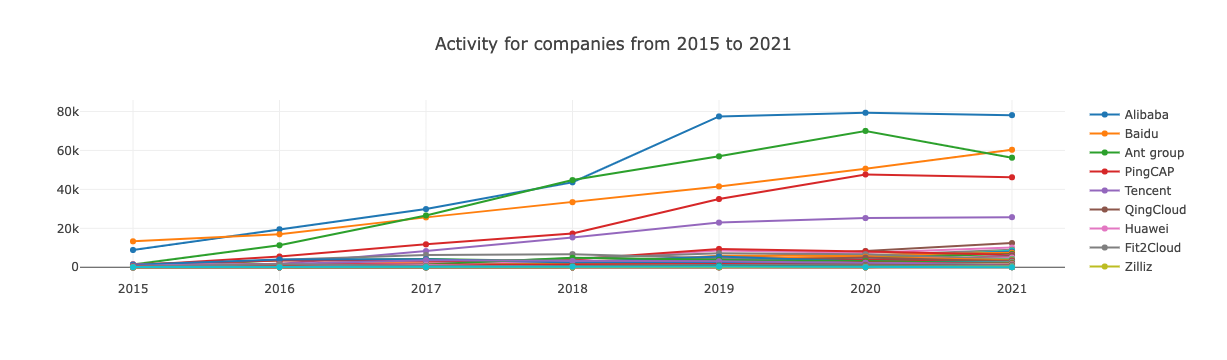

In [5]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getRepoActivity({labelIntersect: ['Company', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.name };
    }), {title: `Activity for companies from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

- getUserActivity

This function will return the user activity with the config param.

Here is an example of k8s-ci-robot and vscode-triage-bot by year from 2015 to 2021.

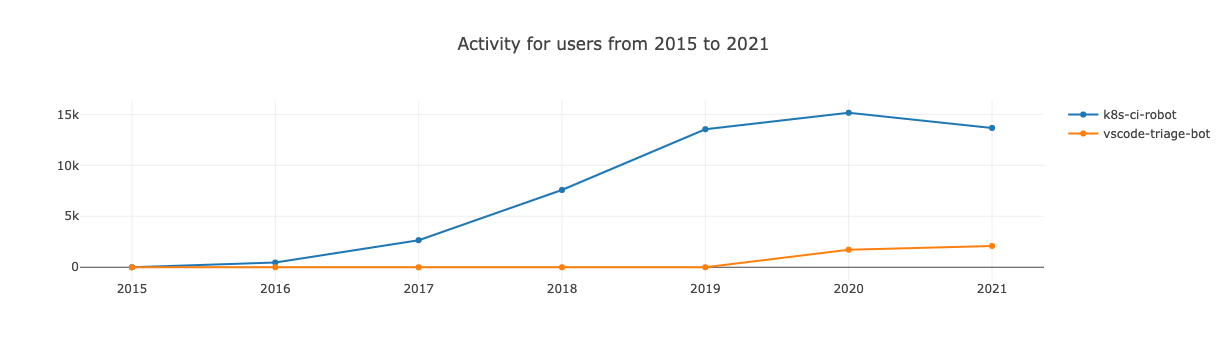

In [6]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.activity.getUserActivity({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year'}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.activity, mode: 'scatter', name: row.name };
    }), {title: `Activity for users from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

#### Attention

Attention index is developed by X-lab team. Attention index uses `WatchEvent` and `ForkEvent` in GitHub event log which can be used to reflect the attention a repo get in a period of time but without any actual contributions to the repo.

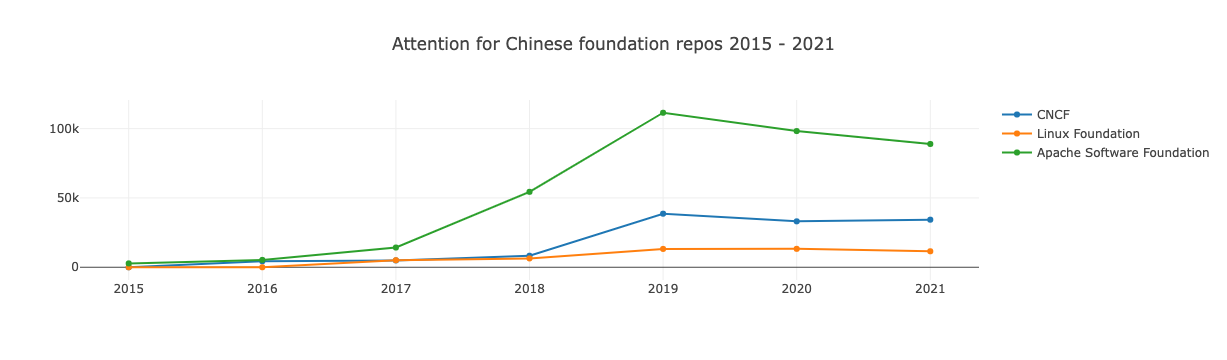

In [7]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.attention.getAttention({labelIntersect: ['Foundation', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Foundation', groupTimeRange: 'year', limit: -1 }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.attention, mode: 'scatter', name: row.name };
    }), {title: `Attention for Chinese foundation repos ${startYear} - ${endYear}`, xaxis: {type: 'category'}});
});

#### OpenRank

OpenRank is an index introduced by X-lab, OpenRank uses activity index as foundamental data to generate a global developement network with developers and repos as node and activity relation as edges.

And then use a PageRank-like algorithm with heterogeneous information networks support called HINRank to rank all the developers and repos together to find out which is more important in the open source world.

- getRepoOpenrank

This function will return repo OpenRank with the config param.

Here is an example of all Chinese projects under foundation group by Foundation and by year from 2015 to 2021.

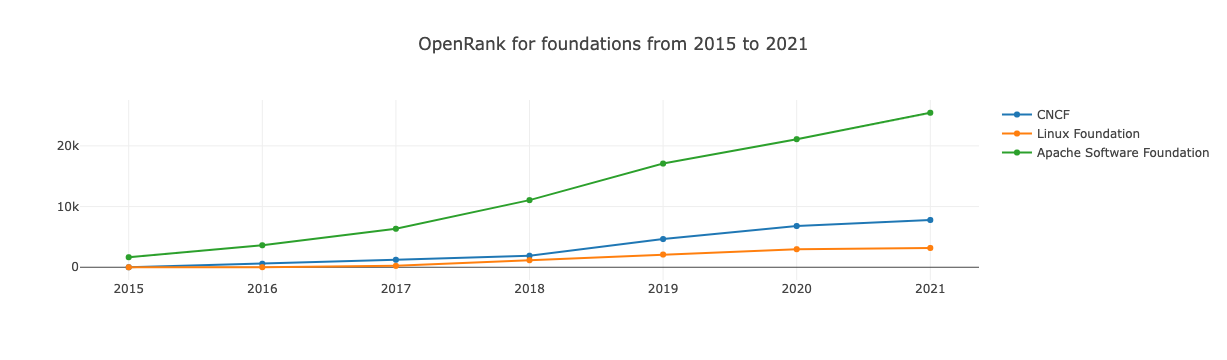

In [8]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getRepoOpenrank({labelIntersect: ['Foundation', ':regions/China'], startYear, startMonth, endYear, endMonth, groupBy: 'Foundation', groupTimeRange: 'year', limit:  -1 }).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.openrank, mode: 'scatter', name: row.name };
    }), {title: `OpenRank for foundations from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

- getUserOpenrank

This function will return the user OpenRank with the config param.

Here is an example of k8s-ci-robot and vscode-triage-bot by year from 2015 to 2021.

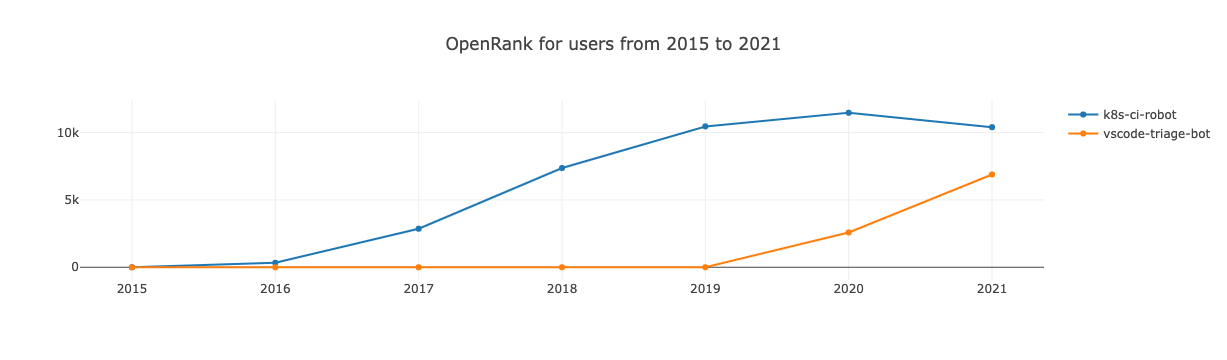

In [9]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.index.openrank.getUserOpenrank({userLogins: ['k8s-ci-robot', 'vscode-triage-bot'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'year'}).then(data => {
    openDigger.render.plotly(data.map(row => {
        return { x, y: row.openrank, mode: 'scatter', name: row.name };
    }), {title: `OpenRank for users from ${startYear} to ${endYear}`, xaxis: {type: 'category'}});
});

### Metric

OpenDigger also provides lots of metric implementations to dive into repos.

Many metrics are from CHAOSS community.

#### Code Change Commits

Code Change Commits is a CHAOSS metric，refer to https://chaoss.community/metric-code-changes/。

Code Change Commits metric has following options:

- messageFilter: A regular expression to filter the commit by commit message like '^feat:.\*' or '^(docs:|refactor:).\*'. Default: null.

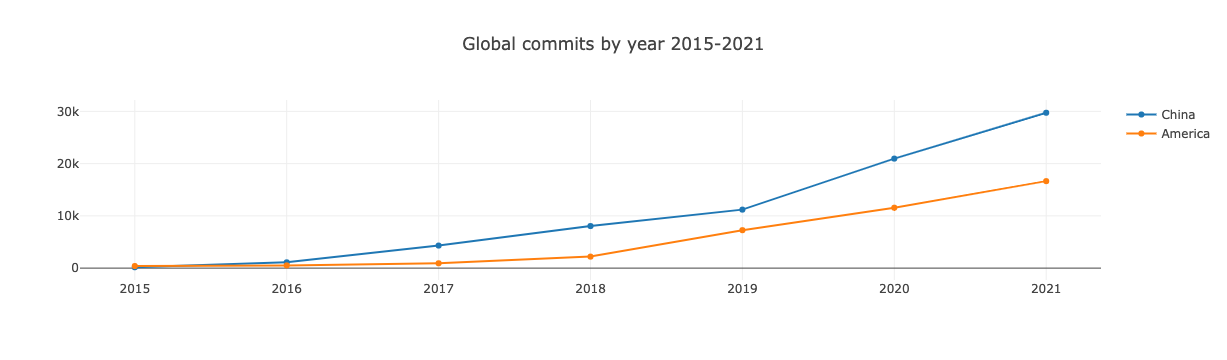

In [10]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.metric.chaoss.codeChangeCommits({ labelIntersect: ['Region'], startYear, startMonth, endYear, endMonth, groupBy: 'Region', groupTimeRange: 'year', limit: -1, options: { messageFilter: '^feat:.*' }, order: 'DESC' }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Global commits by year ${startYear}-${endYear}`, xaxis: {type: 'category'}});
});

#### Issues New

Issues new is a metric from CHAOSS, refer to https://chaoss.community/metric-issues-new/.

Issues New metric ratio value for Microsoft is ["2.8%","8.6%","12%","13%","18%","24%","21%"]


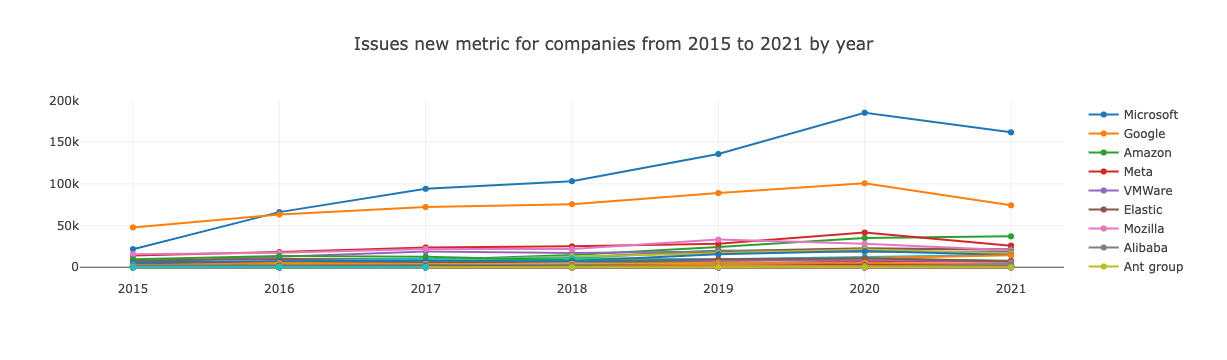

In [11]:
var startYear = 2015, startMonth = 1, endYear = 2021, endMonth = 12, x = [];
for (let y = startYear; y <= endYear; y++) x.push(`${y}`);
openDigger.metric.chaoss.issuesNew({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'year', limit: -1, order: 'DESC' }).then(data => {
    console.log(`Issues New metric ratio value for ${data[0].name} is ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Issues new metric for companies from ${startYear} to ${endYear} by year`, xaxis: {type: 'category'}});
});

#### Issues Closed
Issues closed is a metric from CHAOSS, refer to https://chaoss.community/metric-issues-closed/. 

Issues Closed metric ratio value for Google is ["4.9%","4.7%","6.3%","7.7%","7.0%","11%","9.0%","9.8%","9.6%","10%","9.2%","11%"]


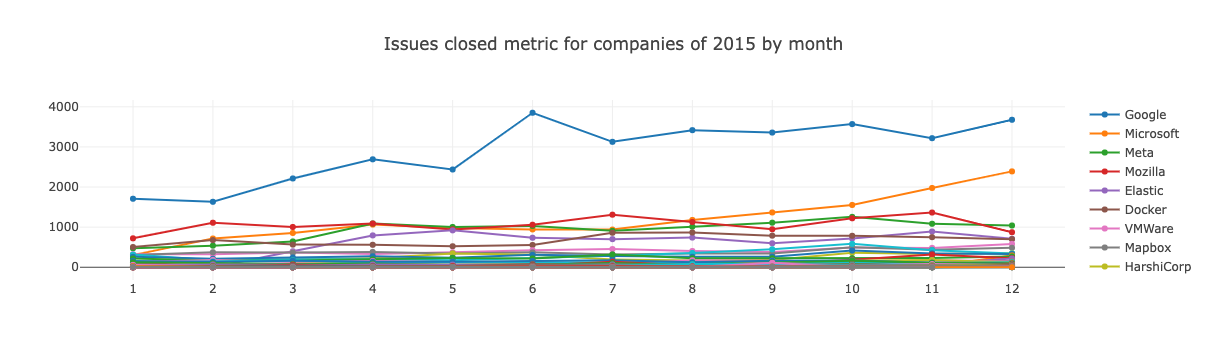

In [12]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.issuesClosed({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: -1, order: 'DESC' }).then(data => {
    console.log(`Issues Closed metric ratio value for ${data[0].name} is ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Issues closed metric for companies of 2015 by month`, xaxis: {type: 'category'}});
});

#### Bus Factor

Bus factor is a metric from CHAOSS, refer to https://chaoss.community/metric-bus-factor/.

Bus factor metrics has following options:

- withBot: `true` or `false`, whether GitHub Apps takes into account. Default: false.
- percentage: the percentage to identify the bus factor developers. Default: 0.5.
- by: `commit`, `change request` or `activity`. How to calculate the bus factor. Default: `activity`.

The bus factor developers for docker/hub-feedback in 2015Q4 are: pik(2), bhalothia(2), mato(3), hoangvuit(2), bcwalrus(3), zjyExcelsior(2), jrhouston(2), mghazizadeh(4), rafalwrzeszcz(2), dszryan(2), kentmw(2), eyal-rounds(2), damienleger(2), ppadial(2), Miguel-Fontes(2), inadarei(3), chrisvire(2), tdanielcox(2), MohammadsM(2), kristiehoward(4), shadowbq(3), dustinlacewell(2), lvlie(2), chriswayg(2), yoanisgil(2), timlinux(2), jmcejuela(2), Karm(2), audreyr(2), fgalan(2), brunzefb(2), wulfgarpro(2), buley(2), carlitux(3), shib1000(2), JeremJR(2), jfisbein(2), janeczku(4), joeldrapper(2), christoph-hipp(2), OrangeCrush(2), vdemeester(2), kadishmal(2), interactiveblueprints(2), urbanchaosmnky(2), strarsis(2), AdieSutcliffe(2), trinitronx(2), xbglowx(2), binhex(2), gerardo8a(2), eNcacz(2), adamkdean(2), teodorescuserban(3), dciccale(2), nathan-osman(2), gregkeys(2), GrahamDumpleton(2), Skeen(2), stepanic(2), bobrik(2), kellyp(2), dg-ratiodata(2), rippinrobr(2), hekaldama(2), sserrano44(2)

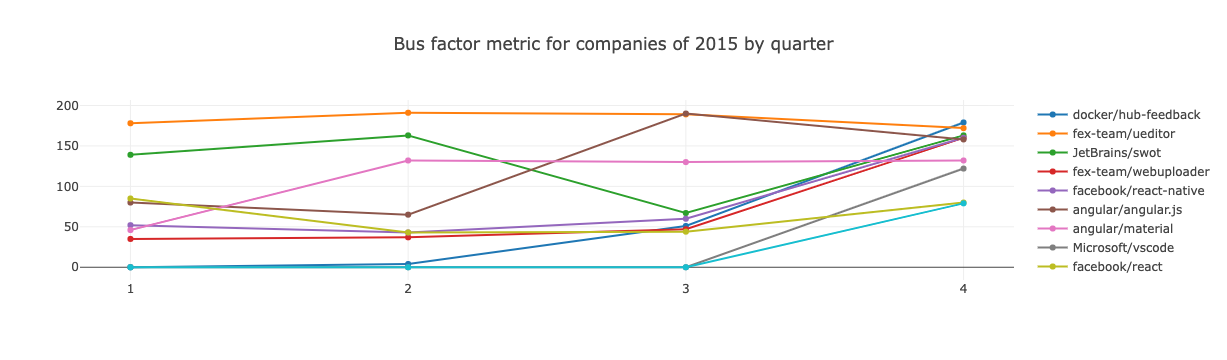

In [13]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.busFactor({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'quarter', limit: 10, options: { withBot: true, percentage: 0.2 }, order: 'DESC' }).then(data => {
    console.log(`The bus factor developers for ${data[0].name} in 2015Q4 are: ${data[0].detail[3].map(d => `${d[0]}(${d[1]})`).join(', ')}. And the total contributions count is ${data[0].total_contributions[3]}.`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.bus_factor,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Bus factor metric for companies of 2015 by quarter`, xaxis: {type: 'category'}});
});

Or get results by commit push.

The bus factor developers for mozilla/gecko-projects in 2015Q4 are: L. David Baron(13), Karl Tomlinson(47), Carsten "Tomcat" Book(35), Markus Stange(13), Tom Tromey(16), Gerald Squelart(50), Gijs Kruitbosch(27), Jan de Mooij(34), Christoph Kerschbaumer(20), Cameron McCormack(20), Nick Thomas(14), Gregor Wagner(14), Chris Peterson(12), Nick Alexander(13), Nicolas Silva(17), Tooru Fujisawa(13), B2G Bumper Bot(98), Valentin Gosu(15), Bob Clary(12), Wes Kocher(35), Kartikaya Gupta(15), Jim Chen(16), Rail Aliiev(52), Mark Banner(18), David Anderson(19), Nicholas Nethercote(41), Andrea Marchesini(15), Jean-Yves Avenard(14), Jon Coppeard(30), Xidorn Quan(22), Florian Quèze(39), JW Wang(41), Nick Fitzgerald(15), Ehsan Akhgari(25), Andreas Pehrson(20), Bevis Tseng(14), Ben Kelly(17). And the total contributions count is 1838.


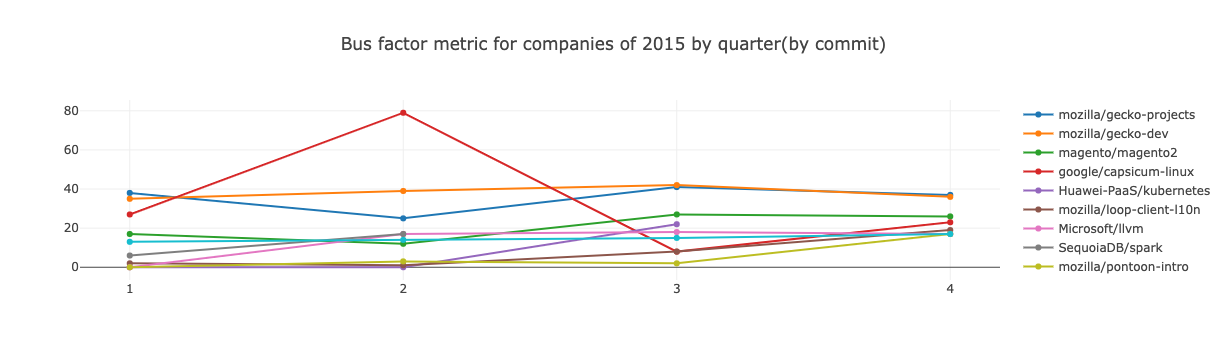

In [14]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.busFactor({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupTimeRange: 'quarter', limit: 10, options: { by: 'commit' }, order: 'DESC' }).then(data => {
    console.log(`The bus factor developers for ${data[0].name} in 2015Q4 are: ${data[0].detail[3].map(d => `${d[0]}(${d[1]})`).join(', ')}. And the total contributions count is ${data[0].total_contributions[3]}.`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.bus_factor,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Bus factor metric for companies of 2015 by quarter(by commit)`, xaxis: {type: 'category'}});
});

#### Change Requests Accepted
Change Requests Accepted is a metric from CHAOSS, refer to https://chaoss.community/metric-change-requests-accepted/. 

Change Requests Accepted ratio value for Microsoft is ["1.9%","5.1%","6.2%","7.9%","8.1%","7.9%","7.2%","9.0%","9.9%","12%","12%","12%"]


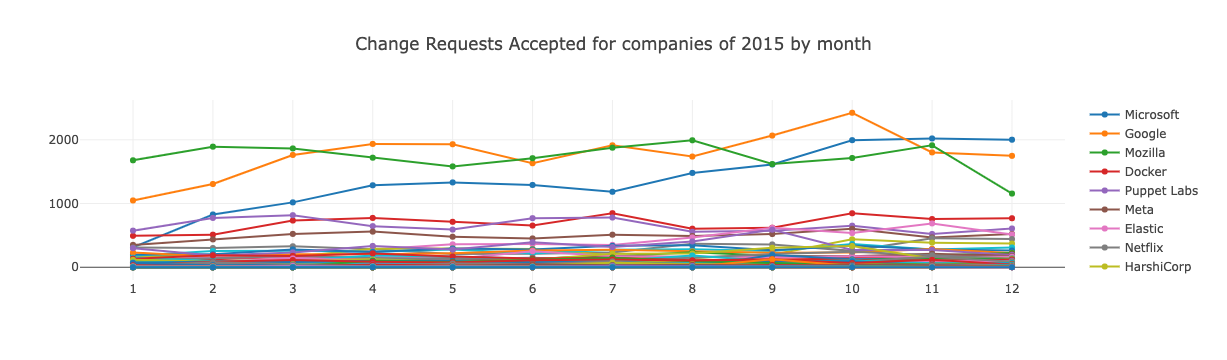

In [15]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.changeRequestsAccepted({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: -1, order: 'DESC' }).then(data => {
    console.log(`Change Requests Accepted ratio value for ${data[0].name} is ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Change Requests Accepted for companies of 2015 by month `, xaxis: {type: 'category'}});
});

#### Change Requests Declined
Change Requests Declined is a metric from CHAOSS, refer to https://chaoss.community/metric-change-requests-declined/.

Change Requests Declined ratio value for Google is ["5.1%","5.1%","5.9%","6.7%","5.9%","6.8%","8.3%","8.7%","11%","13%","11%","13%"]


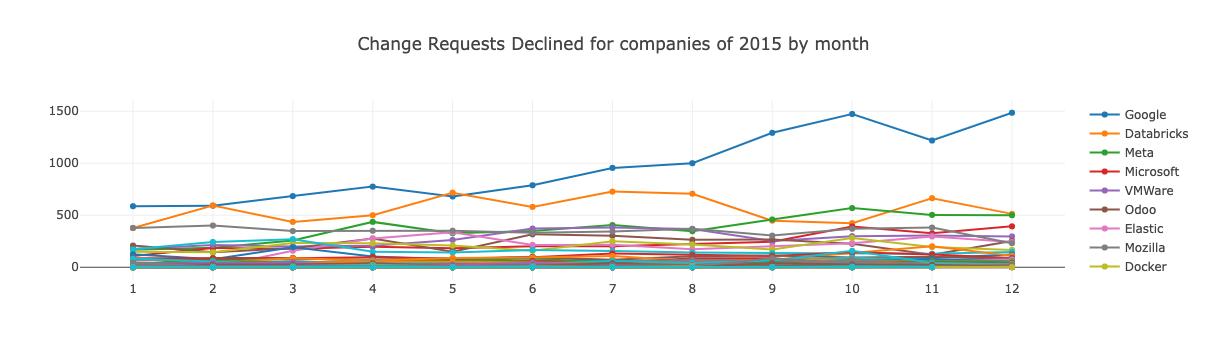

In [16]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.changeRequestsDeclined({ labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, groupBy: 'Company', groupTimeRange: 'month', limit: -1, order: 'DESC' }).then(data => {
    console.log(`Change Requests Declined ratio value for ${data[0].name} is ${JSON.stringify(data[0].ratio)}`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.count,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Change Requests Declined for companies of 2015 by month `, xaxis: {type: 'category'}});
});

#### Change Requests Duration

Change Requests Duration is a metric from CHAOSS, refer to https://chaoss.community/metric-change-requests-duration/.

Change Requests Duration metrics has following options:

- by: `open` or `close`. Use issue open or close time for calculating. Default: `open`.
- type: `avg` or `median`. Use average or median function for aggregating. Default: `avg`.
- unit: `week`, `day`, `hour` or `minute`. Resolution duration unit. Default: `day`.

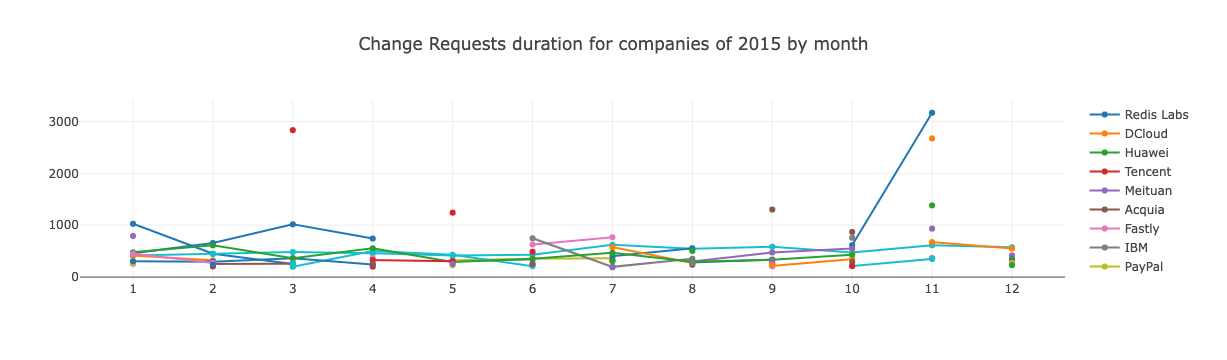

In [17]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossChangeRequestsDuration({
    labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: 10,
    options: {by: 'close', type: 'avg', unit: 'hour' } }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.resolution_duration,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Change Requests duration for companies of 2015 by month `, xaxis: {type: 'category'}});
});

#### Issue Resolution Duration

Issue Resolution Duration is a metric from CHAOSS, refer to https://chaoss.community/metric-issue-resolution-duration/.

Issue resolution duration metrics has following options:

- by: `open` or `close`. Use issue open or close time for calculating. Default: `open`.
- type: `avg` or `median`. Use average or median function for aggregating. Default: `avg`.
- unit: `week`, `day`, `hour` or `minute`. Resolution duration unit. Default: `day`.

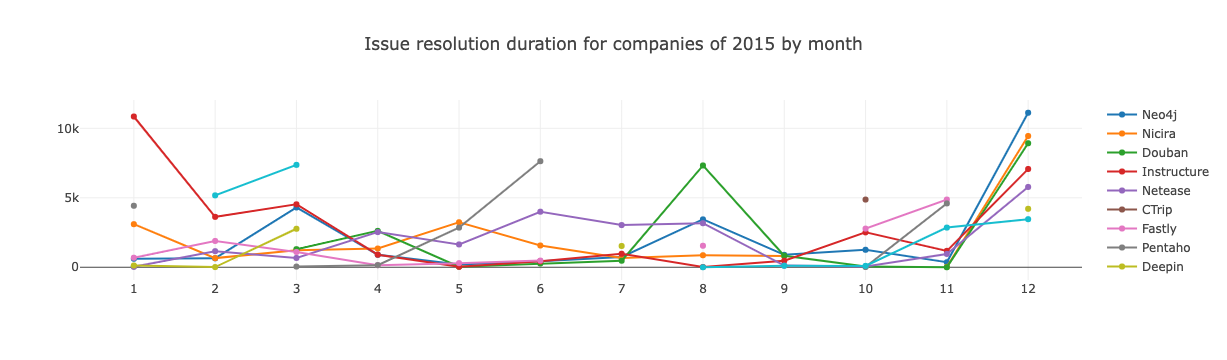

In [18]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossIssueResolutionDuration({
    labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: 10,
    options: {by: 'close', type: 'avg', unit: 'hour' } }).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.resolution_duration,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Issue resolution duration for companies of 2015 by month `, xaxis: {type: 'category'}});
});

#### Code Change Lines

Code Change Lines is a metric from CHAOSS,refer to https://chaoss.community/metric-code-changes-lines/

Code Change Lines metric has following option:

- by:`add` or `remove` or `sum` .Use lines added or lines removed or the sum of them for calculating. Default:`add`.

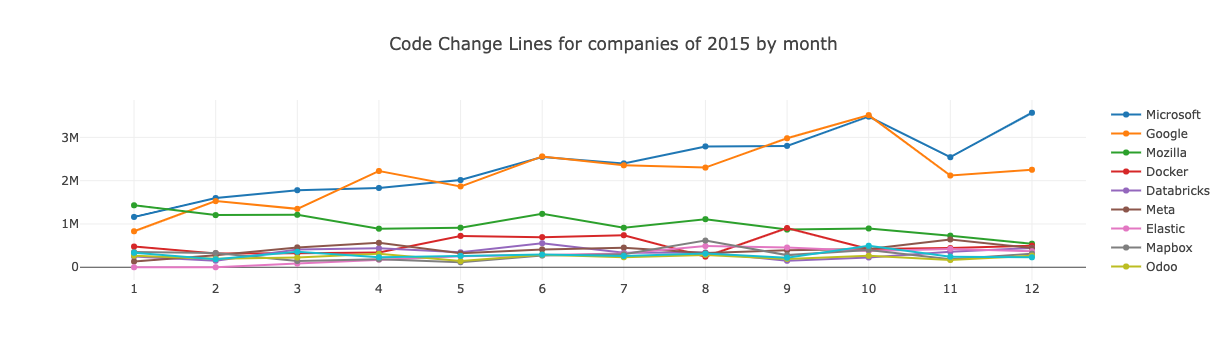

In [19]:
var startYear = 2015, startMonth = 1, endYear = 2015, endMonth = 12, x = [];
for (let y = startMonth; y <= endMonth; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossCodeChangeLines({
labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth, order: 'DESC', groupBy: 'Company', groupTimeRange: 'month', limit: 10,
options:{by: 'add'}}).then(data => {
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.lines,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `Code Change Lines for companies of 2015 by month`, xaxis: {type: 'category'}});
});

#### New Contributors

New Contributors is a metric from CHAOSS,refer to https://chaoss.community/metric-new-contributors/

New Contributors metrics has following options:

- by: `commit`, `change request`. How to calculate the bus factor. Default: `change request`.
- withBot: `true` or `false`, whether GitHub Apps takes into account. Default: false.

The new contributors for docker/docker.github.io in 2016Q4 are:jenglamlow,tim-zju,Kukunin,jefferybradberry,SRaddict,sixeyed,wrrn,liubin,fbouliane,buuren,shin-,wluxion,rothrock,ashishg-qburst,MWeesenaar,aduermael,cavemandaveman,cpuguy83,aureliojargas,hernandesbsousa,dmcgowan,ry4nz,svekars,willseward,mlaventure,joaofnfernandes,buzzedword,emcniece,pkennedyr,tf2manu994,blakethepatton,thaJeztah,stefanwuthrich,magnus-lycka,clemenko,rvernica,ceharris,rillig,Lorel,nguse,u-foka,sanscontext,andrewhsu,rutsky,aboch,MicahZoltu,rhencke,londoncalling,cifkao,czerasz,gdevillele,IRus,4c74356b41,davidmichaelkarr,michelvosje,dragonndev,frdmn,lslezak,solotech,vishesh92,stevensona,jaredrcarlson,pschultz,therobinkim,etki,alexandair,dhauenstein,thomas-bauer,sergei-solomonov,hsluoyz,dgvigil,bfirsh,ntwrkguru,mischah,luojie233,candita,krerkkiat,kurochan,nilsotto,delitescere,RStrydom,PeterDaveHello,holtkamp,ryanore,yuexiao-wang,johndmulhausen,znz,michael-wise,dsheets,athend,mazerty,tanertopal,Samureus,lack3r,dank

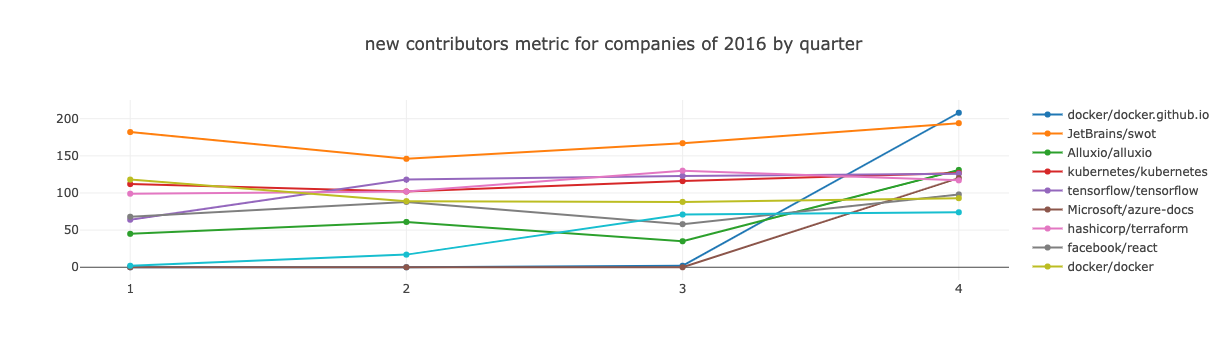

In [20]:
var startYear = 2016, startMonth = 1, endYear = 2016, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossNewContributors({  labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth,order: 'DESC', groupTimeRange: 'quarter', limit: 10, options: { by: 'change request' }}).then(data => {
    console.log(`The new contributors for ${data[0].name} in 2016Q4 are:${data[0].detail[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.new_contributors,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `new contributors metric for companies of 2016 by quarter`, xaxis: {type: 'category'}});
});

Or get results by commit push.

The new contributors for Microsoft/azure-docs in 2016Q4 are:rverschuur,Sreedhar Pelluru,seguler,Liza Poggemeyer,Kelly Gremban,rakshitatandon,Mark Paluch,Vitaliy Konev,Alejandro Guerrero Gonzalez,Abhishek Narain,Nicholas Romyn,Gaurav Mantri,tfitzmac,Olivier Martin,Goran Condric,soeren-lubitz,Jeff Stokes,arramac,Jim Dial,a-tan,Robin Shahan,Ryan Wike,Richard Rundle,Samuel Chan,Blomart Cédric,Dan Rediske,Alex Oancea,Pirmin Felber,Tom FitzMacken,justintian,Devendra Tiwari,Mahesh V S,Kris Crider,TomArcher,misteed-msft,Peter Taylor,MikeRayMSFT,Tim Lovell-Smith,randycampbell,Kristine Toliver (Aquent LLC),Chris Livermore,Takekazu Omi,ShawnJackson,RossAdams,kriscrider,Simon Rolfe,itechedit,bb-froggy,wesmc7777,Michael Hauss,Katie Cumming,Ying Hua,vkonev,Jakob Gottlieb Svendsen,Jarrett Renshaw,mattglabelle,Kevin Williamson,Iain Shepherd,Yufei Huang,rotycenh,Bruce Johnston,Allen Clark (VS),symphonyeyc,vitorfariatomaz,Elizabeth Oldag,Alessandro Segala,Adrian Hall,yongjun tian,Scott Weldon,Guilherme 

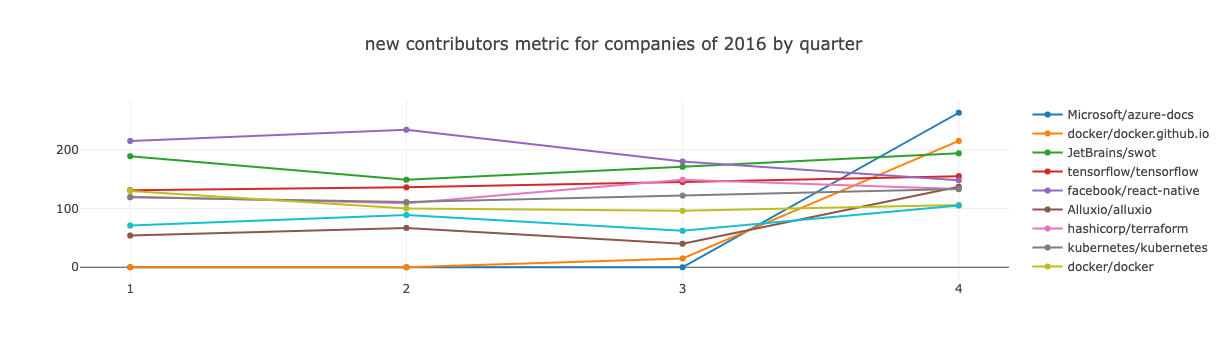

In [21]:
var startYear = 2016, startMonth = 1, endYear = 2016, endMonth = 12, x = [];
for (let y = 1; y <= 4; y++) x.push(`${y}`);
openDigger.metric.chaoss.chaossNewContributors({  labelIntersect: ['Company'], startYear, startMonth, endYear, endMonth,order: 'DESC', groupTimeRange: 'quarter', limit: 10 ,options: { by: 'commit' }}).then(data => {
    console.log(`The new contributors for ${data[0].name} in 2016Q4 are:${data[0].detail[3]}。`);
    openDigger.render.plotly(data.filter(row => row.name != 'Others').map(row => {
        return {
            x,
            y: row.new_contributors,
            mode: 'scatter',
            name: row.name
        };
    }), {title: `new contributors metric for companies of 2016 by quarter`, xaxis: {type: 'category'}});
});

### Driver

In OpenDigger, we provided two drivers for users to make thier own SQL request and get data directly from the database.

#### Clickhouse

Clickhouse driver is used to access the original GitHub event log data from 2015 to now.

The driver can be accessed by `openDigger.driver.clickhouse` and provide a function `query(:sql)` to query data.

And example of all log count from 2015 to 2021 shows as below.

[
  { count: '206270890', year: 2015 },
  { count: '311728938', year: 2016 },
  { count: '408626980', year: 2017 },
  { count: '474569903', year: 2018 },
  { count: '599131703', year: 2019 },
  { count: '855442945', year: 2020 },
  { count: '977134774', year: 2021 }
]


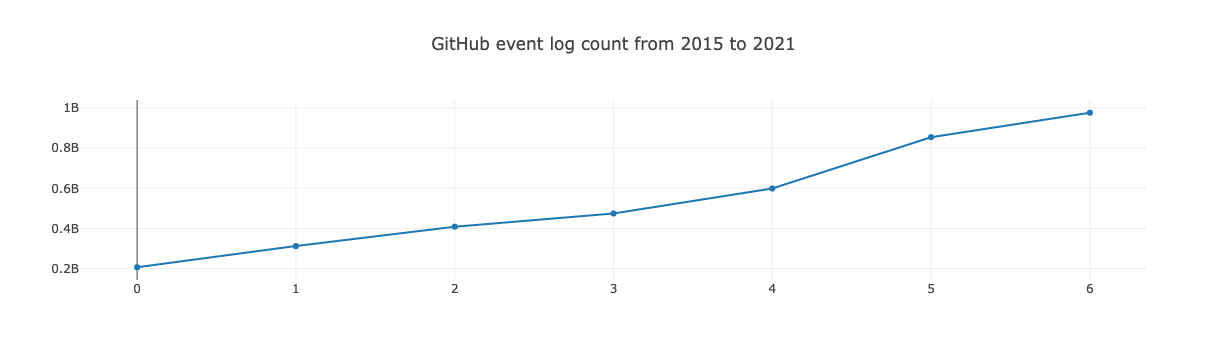

In [8]:
var startYear = 2015, endYear = 2021;
var years = [];
for (var y = startYear; y <= endYear; y++) years.push(y);
openDigger.driver.clickhouse.query(`SELECT COUNT() AS count, toYear(created_at) AS year FROM github_log.events WHERE year >= ${startYear} AND year <= ${endYear} GROUP BY year ORDER BY year`).then(data => {
    console.log(data);  // log the result to console
    openDigger.render.plotly([
        {y: data.map(d => d.count), mode: 'lines+markers', name: 'log_count'}
    ], {title: `GitHub event log count from ${startYear} to ${endYear}`});  // show the result as image
});

#### Neo4j

Neo4j driver is used to access the graph data with activity and openrank aggregate in month, the date range is identical with clickhouse data.

The driver can be accessed by `openDigger.driver.neo4j` and provide a function `query(:sql,:param)` to query data.

And example of `alibaba` org openrank of 2021 by every month shows as below.

[
  {
    open_rank_20211: 1378.2449947086238,
    open_rank_20212: 1205.9290687883301,
    open_rank_20213: 1198.0659094044643,
    open_rank_20214: 1309.535816358224,
    open_rank_20215: 1217.7917311759222,
    open_rank_20216: 1308.4420165438437,
    open_rank_20217: 1397.4789267862357,
    open_rank_20218: 1341.1264339608747,
    open_rank_20219: 1290.6398701659832,
    open_rank_202110: 869.2497420097089,
    open_rank_202111: 1147.450127156078,
    open_rank_202112: 1340.6250216589958
  }
]


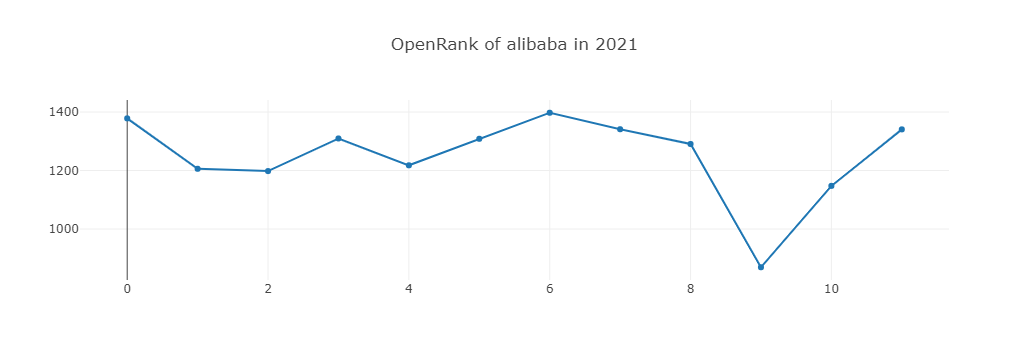

In [12]:
var startMonth = 1, endMonth = 12, org = 'alibaba';
var monthQuery = [];
for (var m = startMonth; m <= endMonth; m++) monthQuery.push(`SUM(COALESCE(r.open_rank_2021${m}, 0.0)) AS open_rank_2021${m}`);
openDigger.driver.neo4j.query(`MATCH (r:Repo) WHERE r.org_login='${org}' RETURN ${monthQuery.join(',')}`).then(data => {
    console.log(data);  // log to console
    openDigger.render.plotly([
        {y: Object.values(data[0]), mode: 'lines+markers', name: 'open_rank'}
    ], {title: `OpenRank of ${org} in 2021`});  // show the result as image
});